# 7. ML Comparisons - Part 1
To be able to determine which algorithm works best for our data, TNO would like to see a comparison of scores for several Machine Learning methods. In this notebook, multiple models will be trained with the same preprocessing method (and therefore the same dataset). All scores like recall and precision will be measured. 

In [1]:
import pandas as pd
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from preprocessing import PreProcessor

pp = PreProcessor()

data = pd.read_csv('darkweb/data/agora.csv')

categories = data[' Category']
categories_main = data[' Category'].apply(lambda x: x.split('/')[0])
descriptions = data[' Item'] + " " + data[' Item Description']
descriptions_preprocessed = descriptions.apply(lambda d: pp.preprocess(str(d)))

## Different dataframes
Here, we create two different dataframes to be able to distinguish between main- and sub-categories.

In [2]:
# Sub
df = pd.DataFrame({'Category': categories, 'Item Description': descriptions_preprocessed})
df = df[pd.notnull(df['Item Description'])] # no empty descriptions
df = df[df.groupby('Category')['Category'].transform(len) > 1] # only categories that appear more than once

df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
features = tfidf.fit_transform(df['Item Description'])
labels = df.category_id

# Main
df_main = pd.DataFrame({'Category': categories_main, 'Item Description': descriptions_preprocessed})
df_main = df_main[pd.notnull(df_main['Item Description'])] # no empty descriptions
df_main = df_main[df_main.groupby('Category')['Category'].transform(len) > 1] # only categories that appear more than once

df_main['category_id'] = df_main['Category'].factorize()[0]
category_id_df_main = df_main[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id_main = dict(category_id_df_main.values)
id_to_category_main = dict(category_id_df_main[['category_id', 'Category']].values)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
features_main = tfidf.fit_transform(df_main['Item Description'])
labels_main = df_main.category_id

df_main.head()

,Category,Item Description,category_id
0,Services,month huluplu gift code month huluplu code wor...,0
1,Services,pay tv sky uk sky germani hd tv much cccam ser...,0
2,Services,offici account creator extrem tag submiss fix ...,0
3,Services,vpn tor sock tutori setup vpn tor sock super s...,0
4,Services,facebook hack guid guid teach hack facebook ac...,0


## Training
After preprocessing, we train all models and predict with our test data. Note: a few weeks later, some parameters were changed. For example: random forest max_depth was increased from the standard 3 to 108 (1 for each category). This improved performance of that model drastically, but it still was not better than for example Linear SVC. 

In [3]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

main = False

if main:
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features_main, labels_main, df_main.index, test_size=0.33, random_state=0)
else:
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
    
linearSVCModel = LinearSVC()
randomForestClassifierModel = RandomForestClassifier(n_estimators=200, max_depth=108, random_state=0)
multinomialNBModel = MultinomialNB()
logisticRegressionModel = LogisticRegression(random_state=0)
SGDClassifierModel = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-5, max_iter=1000, tol=1e-3, class_weight='balanced')

linearSVCModel.fit(X_train, y_train)
randomForestClassifierModel.fit(X_train, y_train)
multinomialNBModel.fit(X_train, y_train)
logisticRegressionModel.fit(X_train, y_train)
SGDClassifierModel.fit(X_train, y_train)

y_predLinearSVC = linearSVCModel.predict(X_test)
y_predRandomForestClassifier = randomForestClassifierModel.predict(X_test)
y_predMultinomialNB = multinomialNBModel.predict(X_test)
y_predLogisticRegression = logisticRegressionModel.predict(X_test)
y_predSGDClassifier = SGDClassifierModel.predict(X_test)

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


## Confusion matrices and scores
For insights into the classification process, we visualize the different models by showing their predictions into a confusion matrix. First, we create a functions that plots a confusion matrix. Then we plot al matrices and show scores of the models.

In [4]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics

def plot_confusion_matrix(modelName, modelPrediction):
    conf_mat = confusion_matrix(y_test, modelPrediction)
    fig, ax = plt.subplots(figsize=(75,25))
    sns.heatmap(conf_mat, annot=True, fmt='d', robust=True,
                xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)

    plt.title(modelName + " Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig('Confusion Matrix - ' + modelName + '.png', bbox_inches='tight')
    plt.show()

### Linear SVC

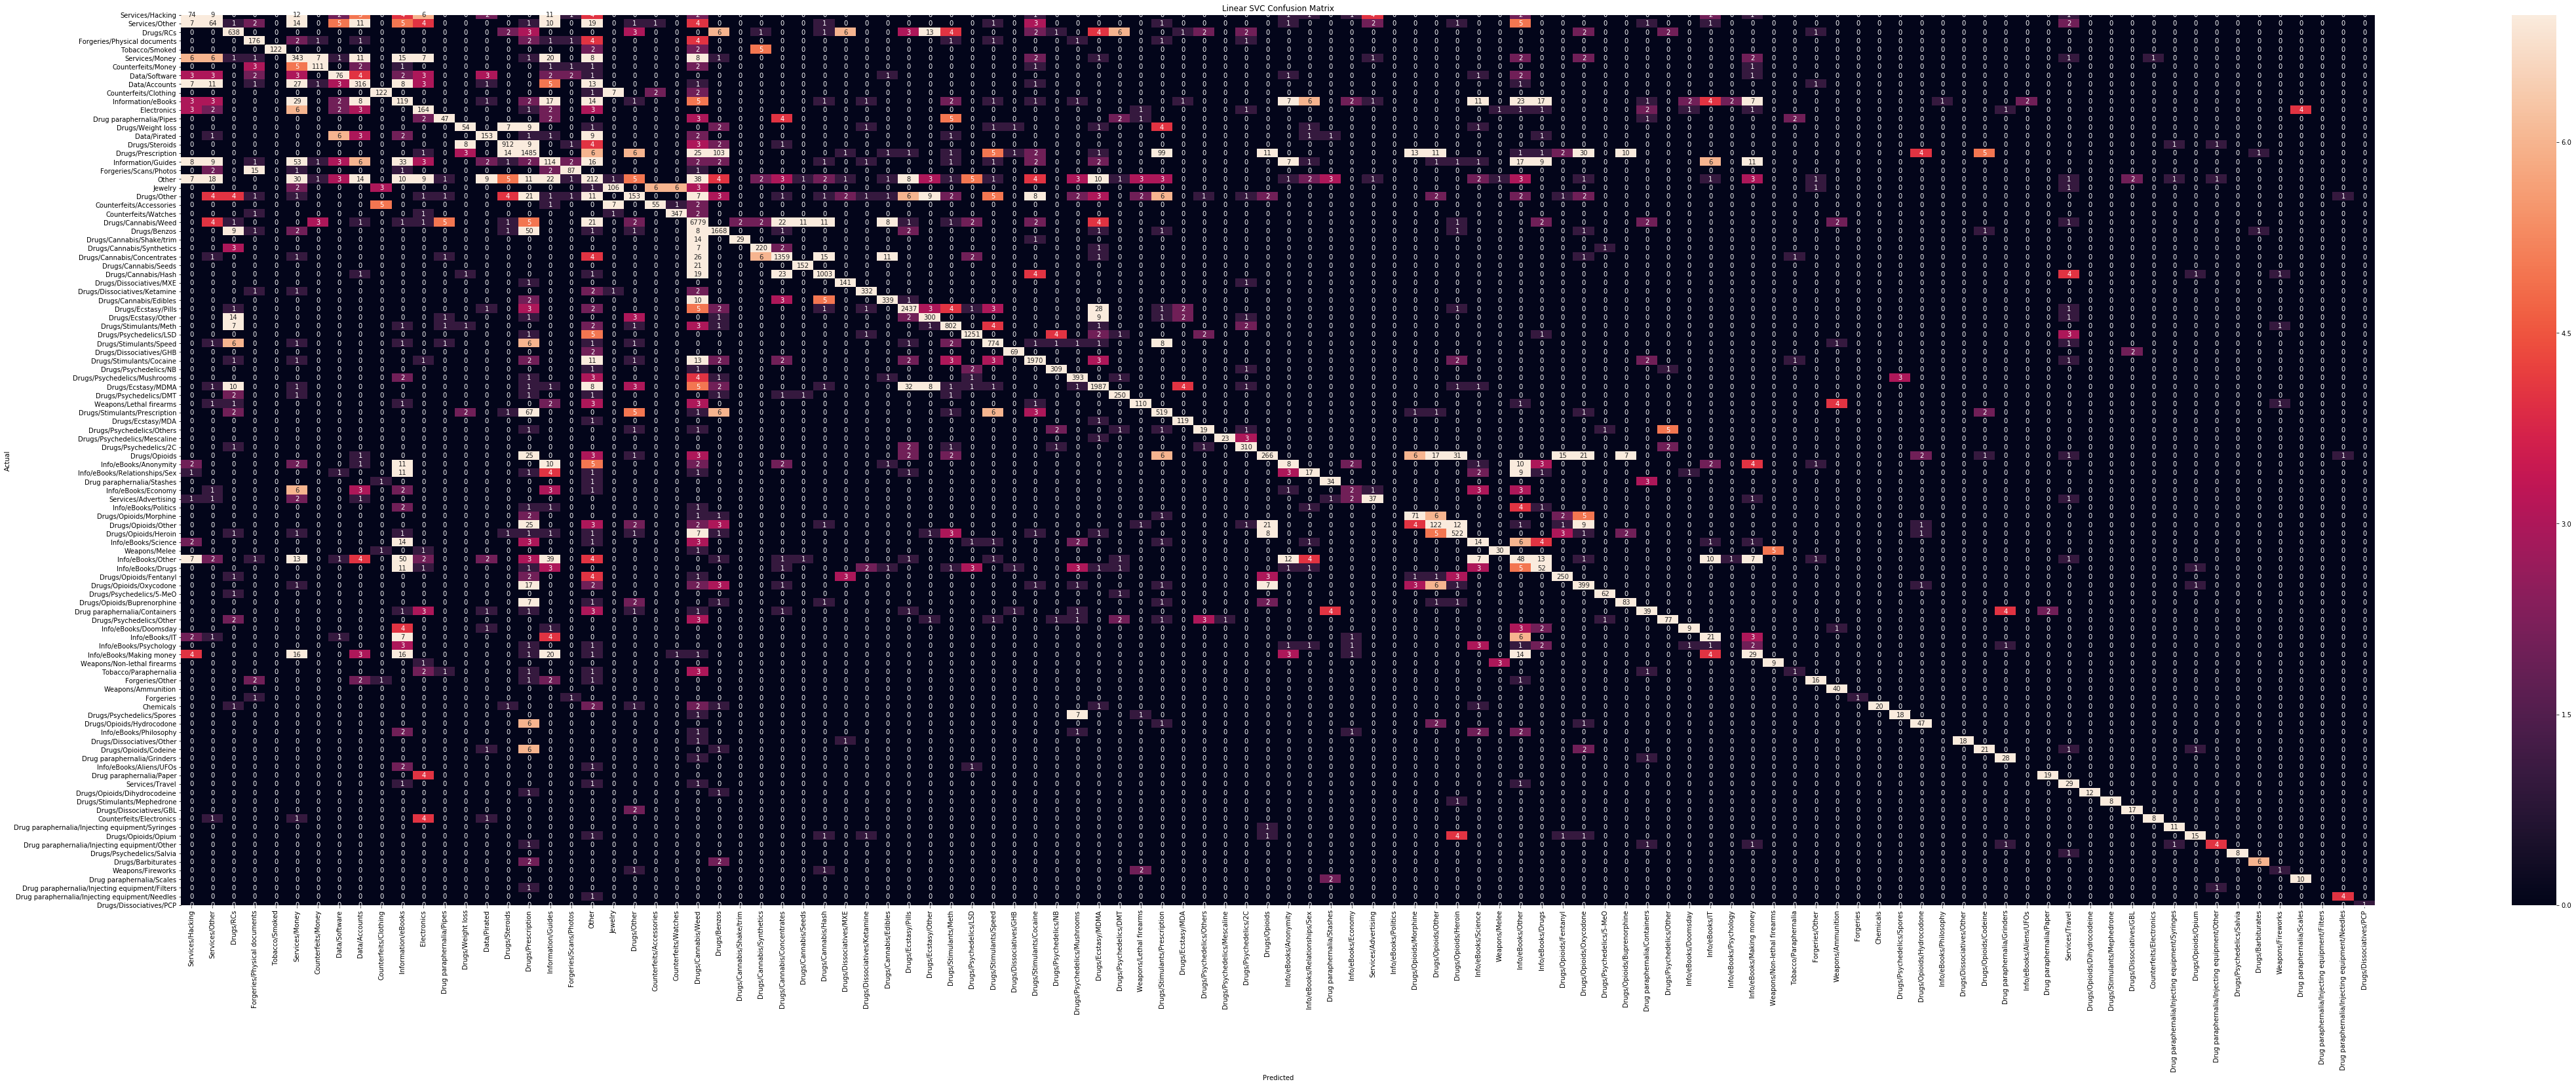

In [5]:
plot_confusion_matrix('Linear SVC', y_predLinearSVC)

In [6]:
print(metrics.classification_report(y_test, y_predLinearSVC, target_names=df['Category'].unique()))

                                                 precision    recall  f1-score   support

                               Services/Hacking       0.54      0.51      0.52       146
                                 Services/Other       0.44      0.38      0.41       168
                                      Drugs/RCs       0.90      0.91      0.90       703
                   Forgeries/Physical documents       0.84      0.89      0.87       197
                                 Tobacco/Smoked       1.00      0.93      0.96       131
                                 Services/Money       0.59      0.77      0.67       448
                             Counterfeits/Money       0.89      0.86      0.87       129
                                  Data/Software       0.72      0.69      0.70       110
                                  Data/Accounts       0.79      0.79      0.79       400
                          Counterfeits/Clothing       0.92      0.91      0.91       134
                    

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Random Forest Classifier

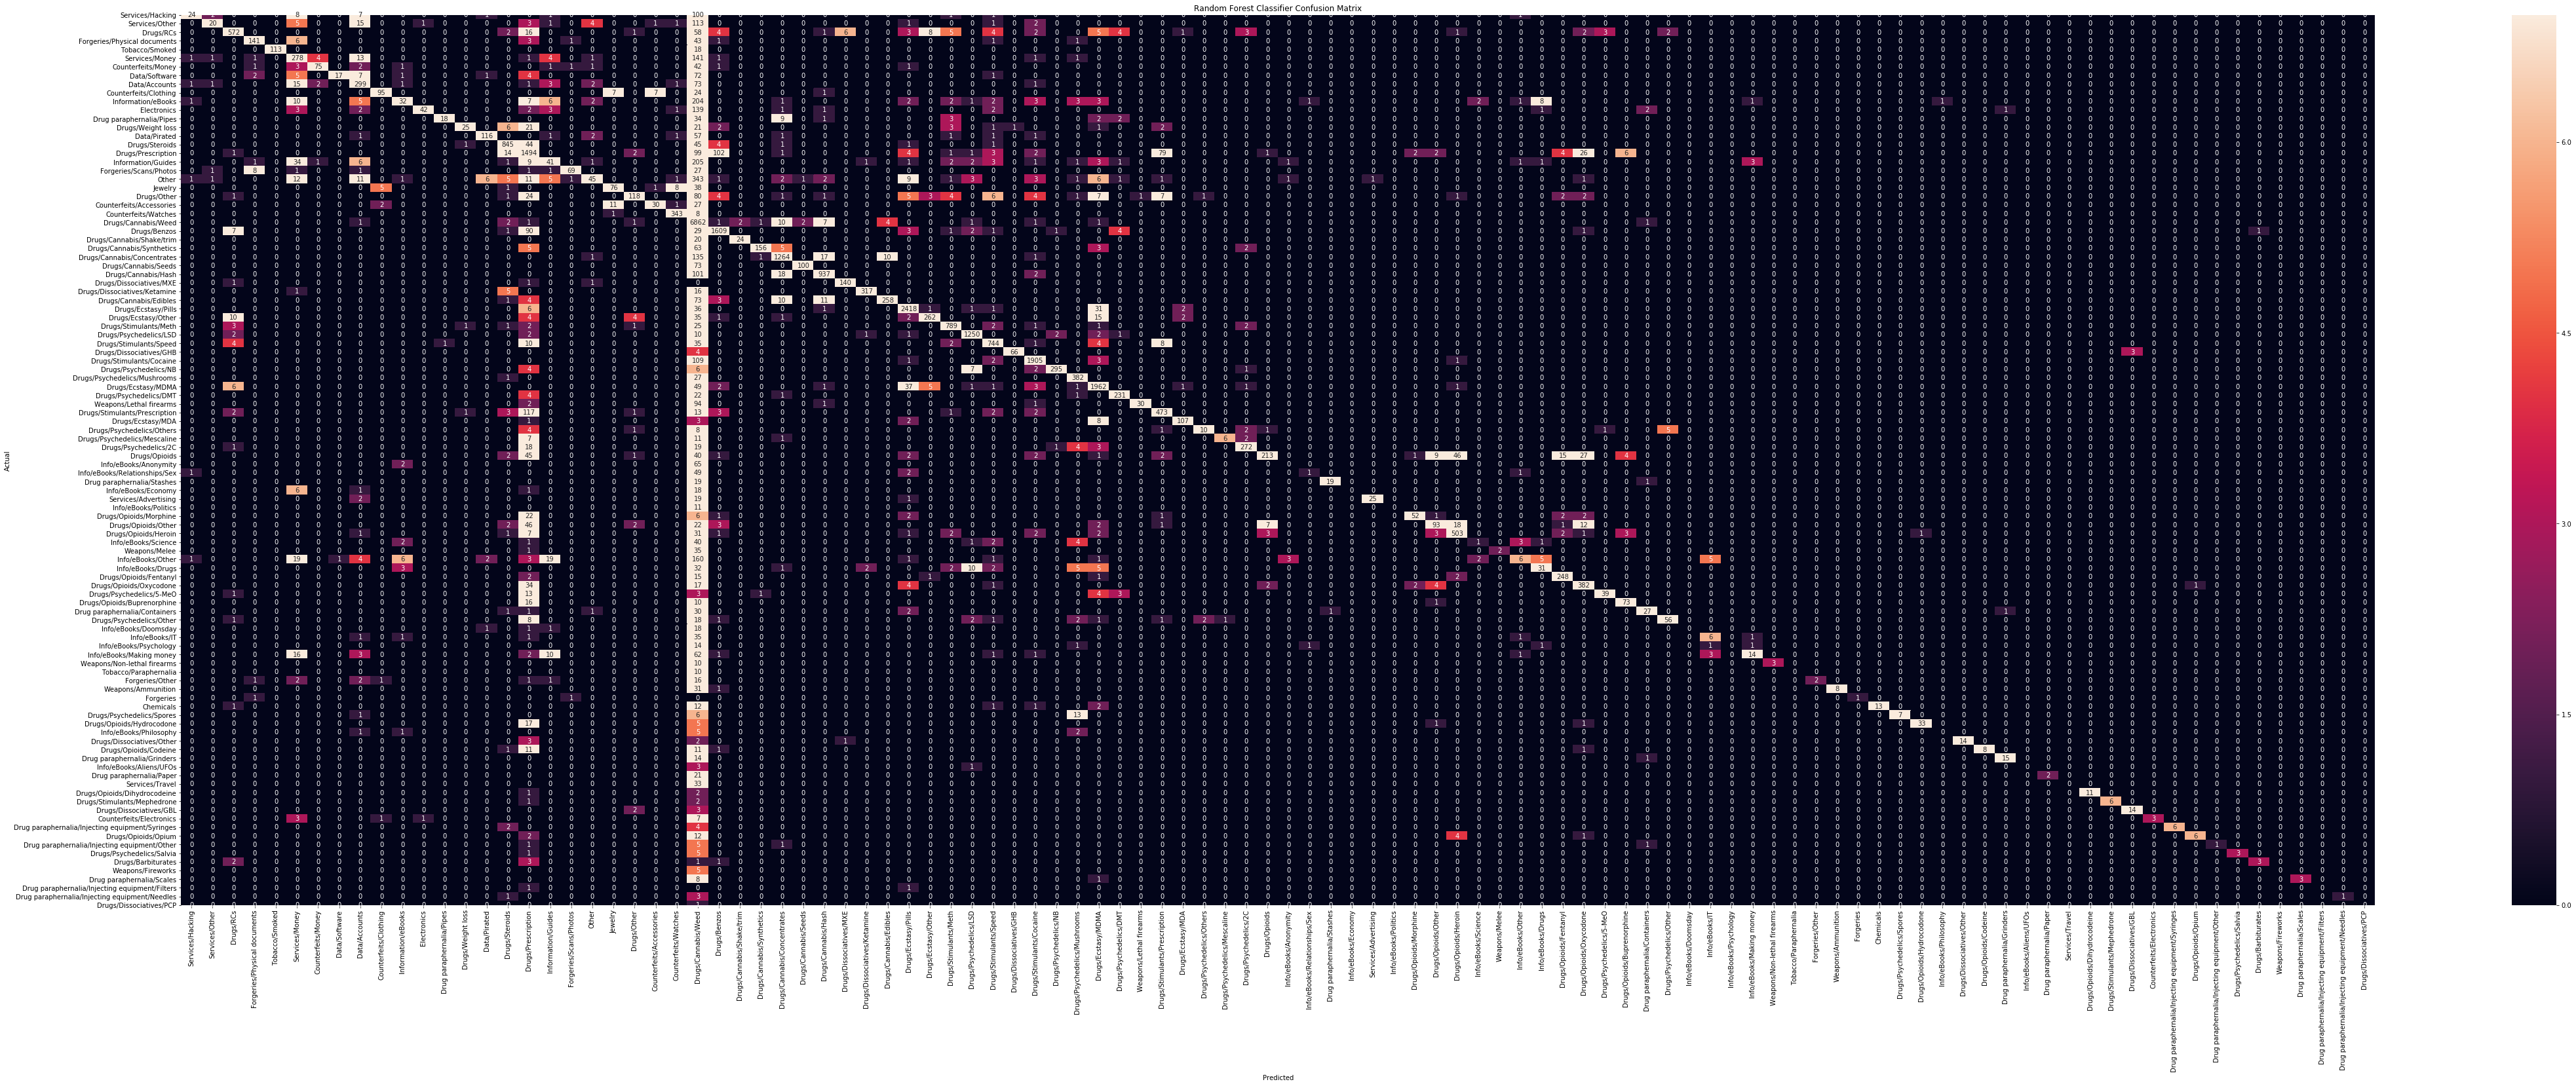

In [7]:
plot_confusion_matrix('Random Forest Classifier', y_predRandomForestClassifier)

In [8]:
print(metrics.classification_report(y_test, y_predRandomForestClassifier, target_names=df['Category'].unique()))

                                                 precision    recall  f1-score   support

                               Services/Hacking       0.80      0.16      0.27       146
                                 Services/Other       0.77      0.12      0.21       168
                                      Drugs/RCs       0.93      0.81      0.87       703
                   Forgeries/Physical documents       0.90      0.72      0.80       197
                                 Tobacco/Smoked       1.00      0.86      0.93       131
                                 Services/Money       0.65      0.62      0.64       448
                             Counterfeits/Money       0.91      0.58      0.71       129
                                  Data/Software       0.94      0.15      0.27       110
                                  Data/Accounts       0.77      0.75      0.76       400
                          Counterfeits/Clothing       0.91      0.71      0.80       134
                    

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Multinomial Naive Bais

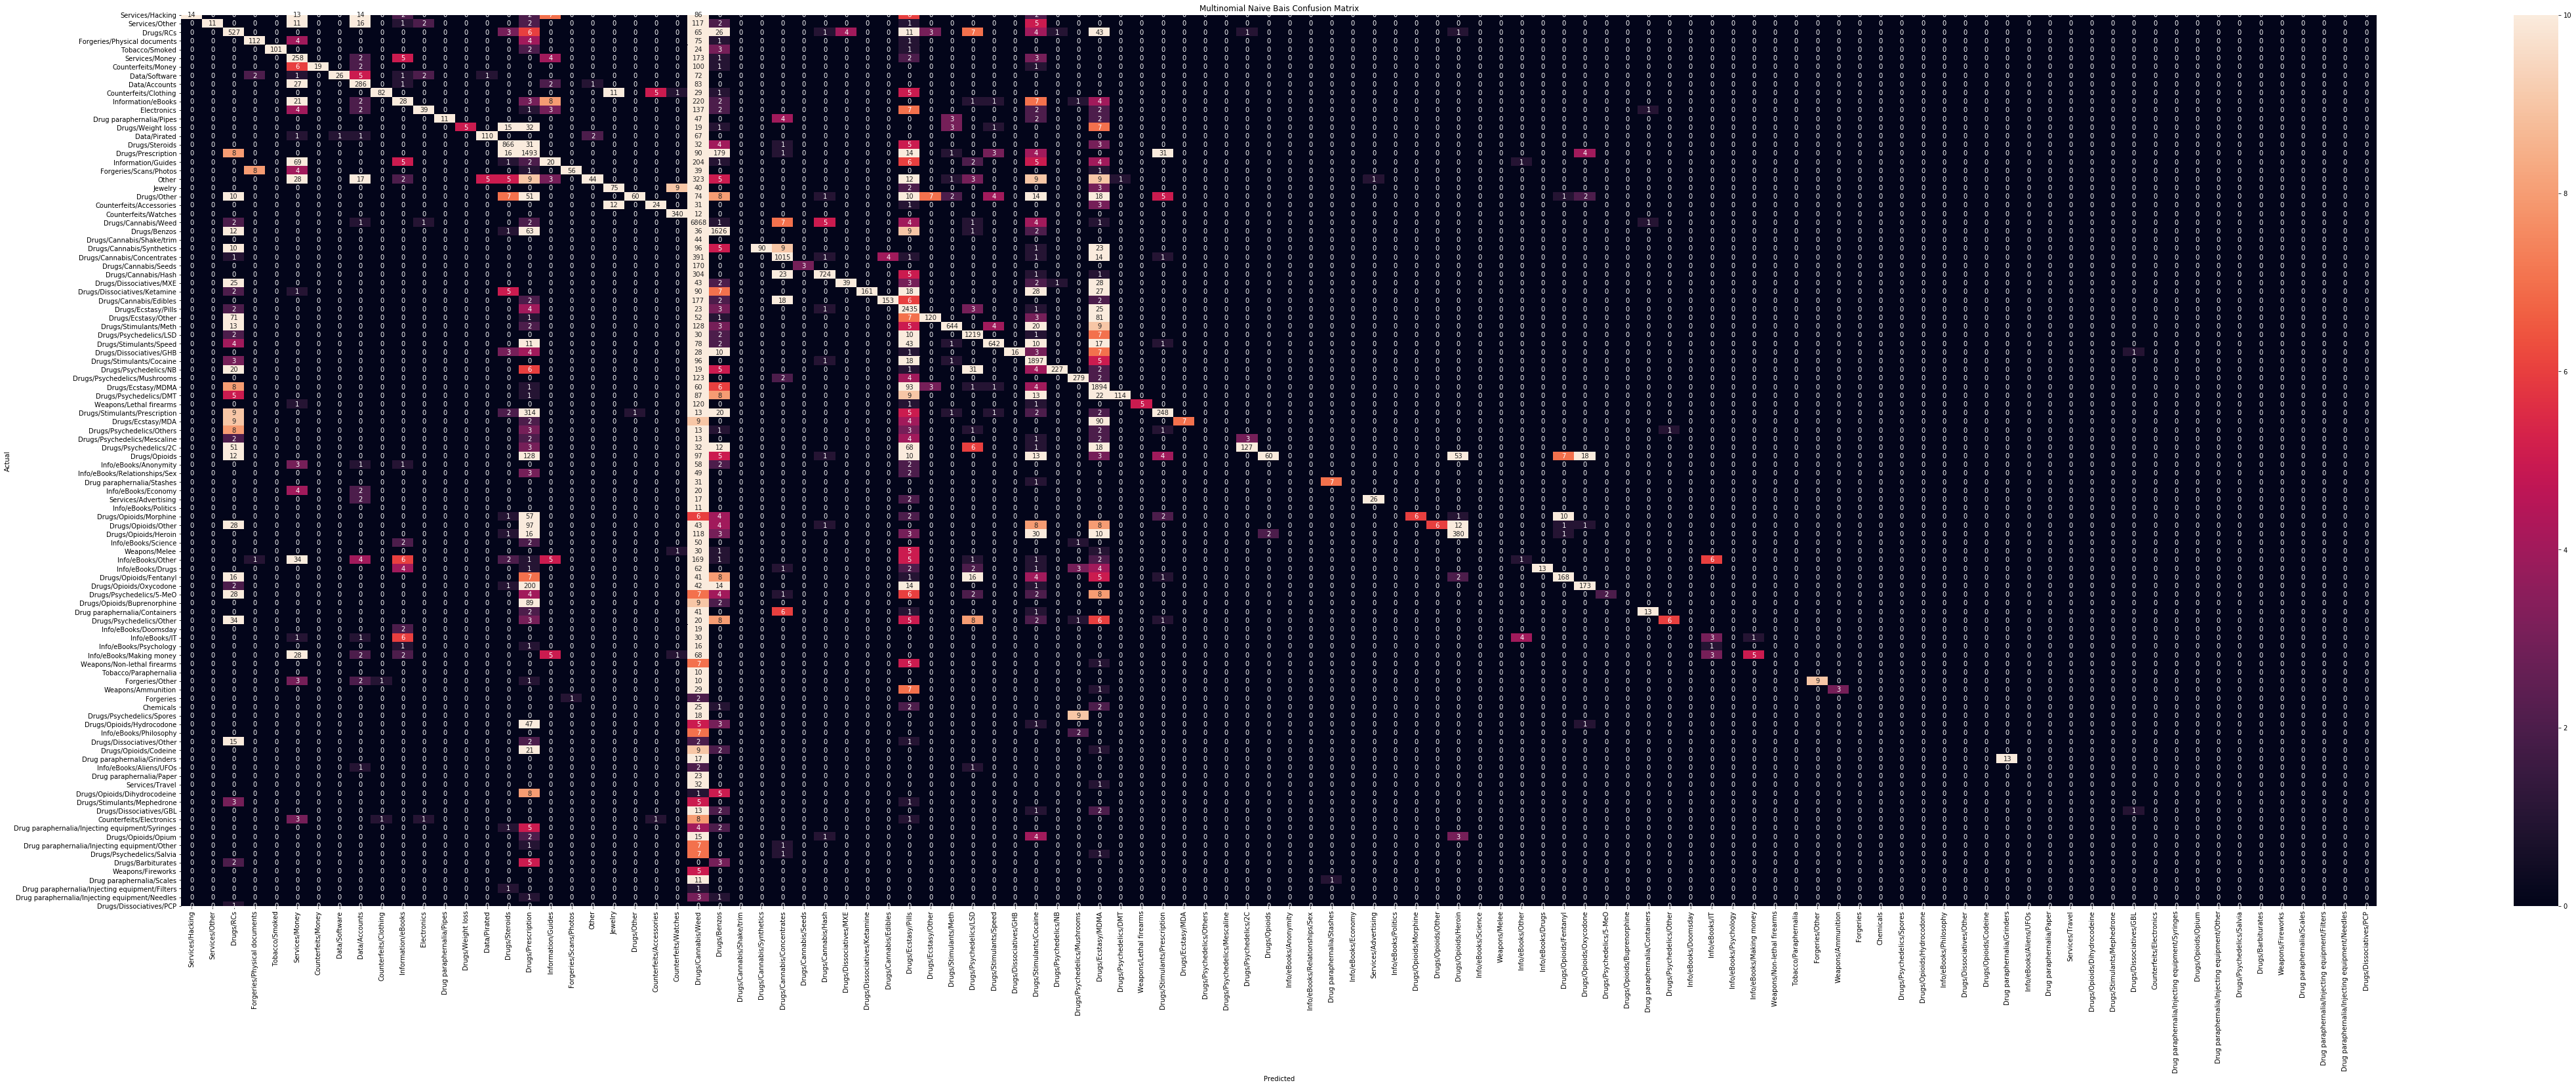

In [9]:
plot_confusion_matrix('Multinomial Naive Bais', y_predMultinomialNB)

In [10]:
print(metrics.classification_report(y_test, y_predMultinomialNB, target_names=df['Category'].unique()))

                                                 precision    recall  f1-score   support

                               Services/Hacking       1.00      0.10      0.17       146
                                 Services/Other       1.00      0.07      0.12       168
                                      Drugs/RCs       0.56      0.75      0.64       703
                   Forgeries/Physical documents       0.91      0.57      0.70       197
                                 Tobacco/Smoked       1.00      0.77      0.87       131
                                 Services/Money       0.49      0.58      0.53       448
                             Counterfeits/Money       1.00      0.15      0.26       129
                                  Data/Software       0.96      0.24      0.38       110
                                  Data/Accounts       0.79      0.71      0.75       400
                          Counterfeits/Clothing       0.98      0.61      0.75       134
                    

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Logistic Regression

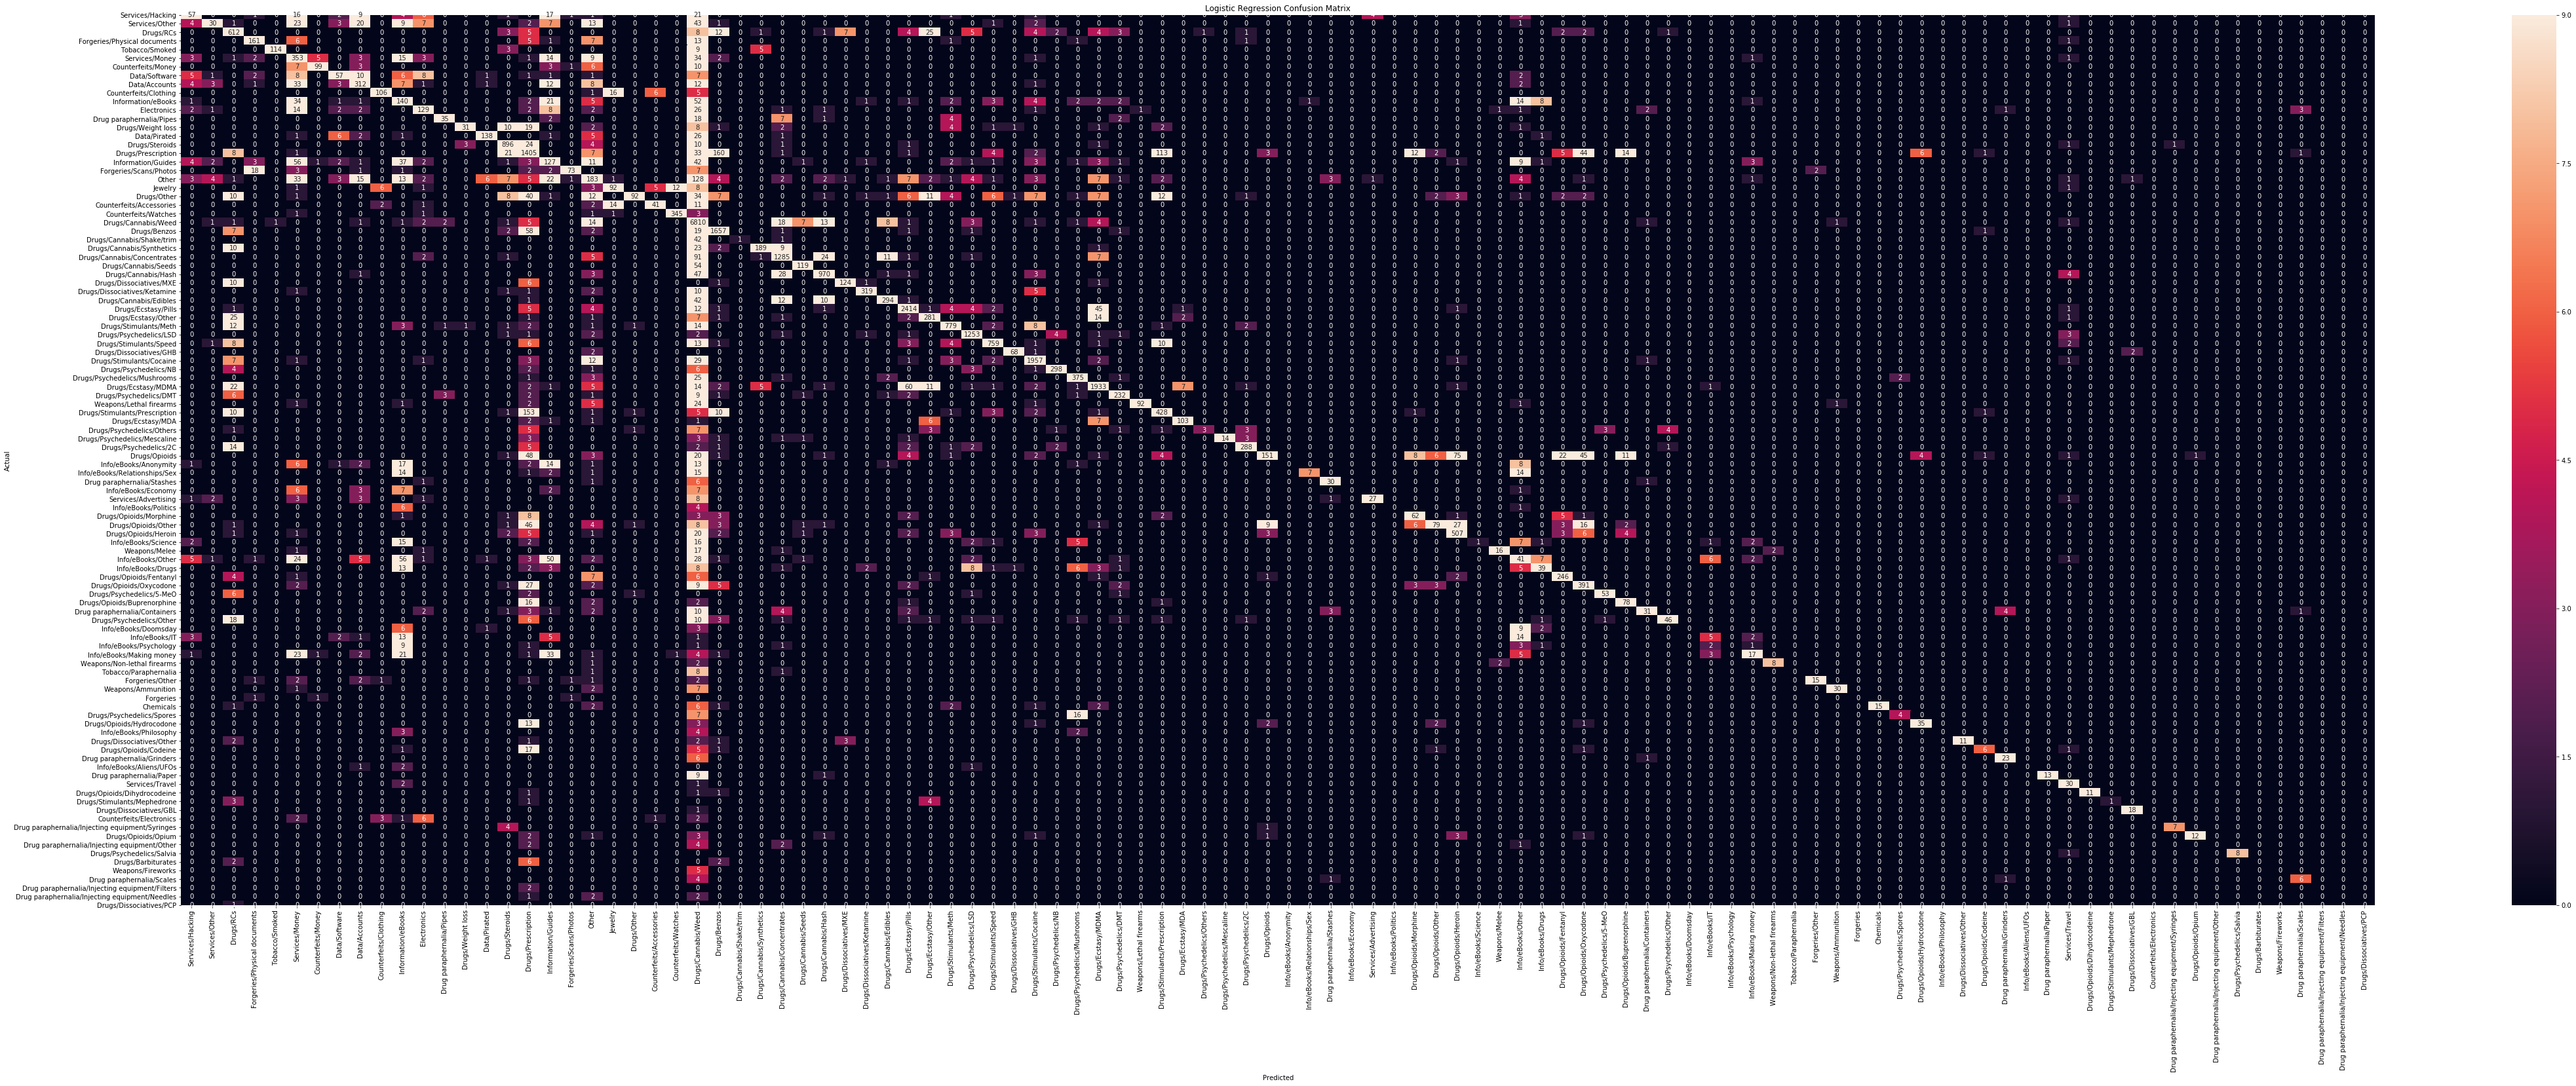

In [11]:
plot_confusion_matrix('Logistic Regression', y_predLogisticRegression)

In [12]:
print(metrics.classification_report(y_test, y_predLogisticRegression, target_names=df['Category'].unique()))

                                                 precision    recall  f1-score   support

                               Services/Hacking       0.59      0.39      0.47       146
                                 Services/Other       0.65      0.18      0.28       168
                                      Drugs/RCs       0.76      0.87      0.81       703
                   Forgeries/Physical documents       0.84      0.82      0.83       197
                                 Tobacco/Smoked       0.99      0.87      0.93       131
                                 Services/Money       0.53      0.79      0.63       448
                             Counterfeits/Money       0.93      0.77      0.84       129
                                  Data/Software       0.70      0.52      0.59       110
                                  Data/Accounts       0.78      0.78      0.78       400
                          Counterfeits/Clothing       0.90      0.79      0.84       134
                    

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### SGD Classifier

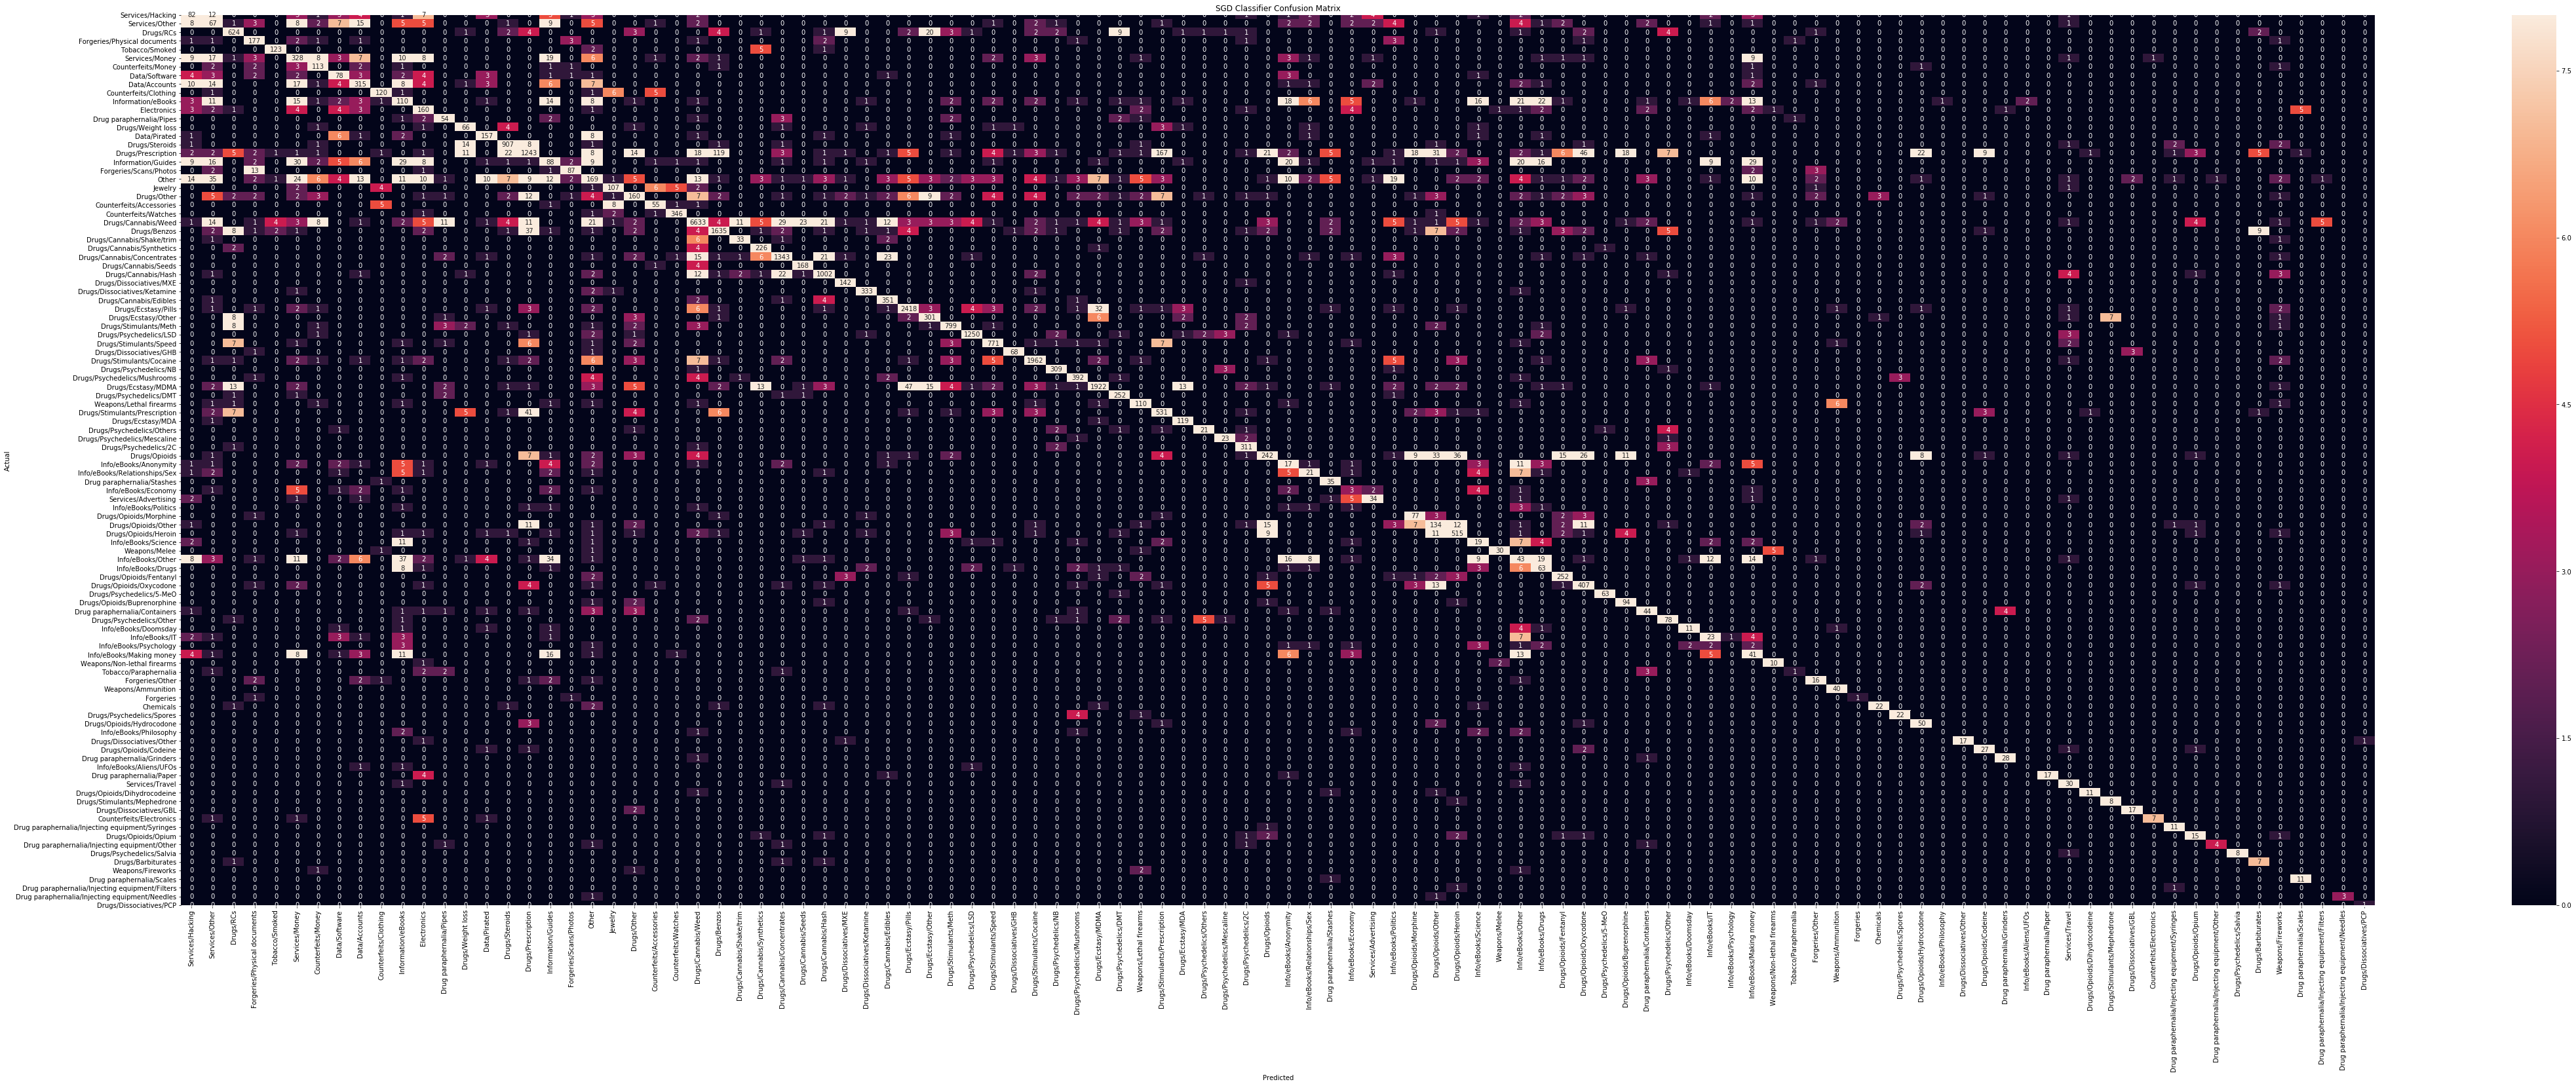

In [13]:
plot_confusion_matrix('SGD Classifier', y_predSGDClassifier)

In [14]:
print(metrics.classification_report(y_test, y_predSGDClassifier, target_names=df['Category'].unique()))

                                                 precision    recall  f1-score   support

                               Services/Hacking       0.48      0.56      0.52       146
                                 Services/Other       0.29      0.40      0.34       168
                                      Drugs/RCs       0.90      0.89      0.89       703
                   Forgeries/Physical documents       0.81      0.90      0.85       197
                                 Tobacco/Smoked       0.94      0.94      0.94       131
                                 Services/Money       0.68      0.73      0.70       448
                             Counterfeits/Money       0.73      0.88      0.80       129
                                  Data/Software       0.61      0.71      0.66       110
                                  Data/Accounts       0.80      0.79      0.79       400
                          Counterfeits/Clothing       0.90      0.90      0.90       134
                    